# Tilable terrain gan

- DC GAN for now
- pending tiling features

In [1]:
%pip install tensorflow h5py pyyaml rasterio


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-04 04:52:46.373505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 04:52:49.698140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 04:52:49.771197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-

In [5]:
import rasterio
import glob
import numpy as np
import random

# Constants
BUFFER_SIZE = 10000
BATCH_SIZE = 32
IMAGE_SIZE = 28
MAX_ALTITUDE = 1105
MIN_ALTITUDE = -23

# 1. Read the GeoTIFF files
file_list = glob.glob("TesisCode/Dataset/download2/*.tif")
ds = tf.data.Dataset.from_tensor_slices(file_list)

# 2. Decode and preprocess the images
def decode_image(filename):
    with rasterio.open(filename.numpy().decode('utf-8')) as src:
        image = src.read()
        image = image[0]
        
    # Resize to desired image size using TensorFlow
    size_rows, size_cols = np.shape(image)
    # random 28x28 crop of np array image
    start_row = random.randint(0, size_rows - IMAGE_SIZE)
    start_col = random.randint(0, size_cols - IMAGE_SIZE)
    image = image[start_row:start_row+IMAGE_SIZE, start_col:start_col+IMAGE_SIZE]

    # Normalize the pixel values to [0,1]
    image = (image - MIN_ALTITUDE) / (MAX_ALTITUDE - MIN_ALTITUDE)
    
    # reshape to 28x28x1
    image = np.expand_dims(image, axis=-1)

    # Convert to float32
    image = tf.cast(image, tf.float32)

    return image

# Use tf.py_function to call the rasterio function in a tensorflow map function
def tf_decode_image(filename):
    return tf.py_function(decode_image, [filename], tf.float32)

ds = ds.map(tf_decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds = ds.cache()

# Use repeat() to loop over the dataset indefinitely
ds = ds.repeat()

# Shuffle and batch the dataset as before
ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


##  2. Viz data and build dataset

In [6]:
# do data transformation
import numpy as np

In [7]:
# setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

## Build NN

In [8]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [9]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [10]:
generator = build_generator()

In [11]:
def build_discriminator():
    model = Sequential()

    # first conv block
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4)) # Might be best to not have
    model.add(Dense(1, activation='sigmoid'))

    return model

In [12]:
discriminator = build_discriminator()

# 4. Construct training loop

# 4.1 Setup losses and optimizers

In [13]:
# Optimizer for both
from tensorflow.keras.optimizers import Adam
# Loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [14]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# 4.2 Subclass model

In [15]:
# Import base model class to subclass our training step
from tensorflow.keras.models import Model

In [16]:
# 3 key functions

class TerrainTileGan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass to base class
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen end disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        ## Compile w/ baseclass
        super().compile(*args, **kwargs)

        # Attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # get the data
        real_images = batch
        # 128 because we start with a linear layer w/ 128 neurons. Gets reshaped lated
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

        # Train discriminator
        with tf.GradientTape() as d_tape:
            # 1. pass real and fake imgs to discriminaotr
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # 2. cresate labels for real and fakes
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # 3. add noise to output to avoid learning too fast
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            ## Not sure if - is good idea.
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # 4. Calculate loss - BINARYCROSSENTROPY
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # 5. Backpropagate -- nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train gen
        with tf.GradientTape() as g_tape:
            # Generate new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss (rewared when disc says fake is real - hence zeros)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            # No need to pass real images bc we're not training discriminator

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss": total_g_loss}
            
    # Also option for train_test

In [17]:
## Alt
# @tf.function
# def train_step():
#     pass

In [18]:
# Create instance of subclassed model
terrainTileGan = TerrainTileGan(generator, discriminator)

In [19]:
# Compile model
terrainTileGan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build callback

In [20]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [21]:
## Create images dir for model
!mkdir -p images

In [22]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))
            tf.summary.image(f'generated_img_{epoch}_{i}', generated_images[i], step=epoch)

## Train

In [23]:
## Setup tensorboard

from tensorflow.keras.callbacks import TensorBoard
from time import time

tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=1, write_graph=True, write_images=True)

In [50]:
import threading
import subprocess

## CHeck if there are any .h5 files in the directory
# if len(os.listdir()) > 0:
#     # If there are, load the latest one
#     latest_gen = max(glob.glob('gen*.h5'))
#     latest_disc = max(glob.glob('disc*.h5'))
#     generator.load_weights(latest_gen)
#     discriminator.load_weights(latest_disc)

def save_weights(iteration):
    generator.save(f'gen{iteration}.h5')
    discriminator.save(f'disc{iteration}.h5')

def run_tensorboard():
    subprocess.call(['tensorboard', '--logdir', 'logs'])

# tb_thread = threading.Thread(target=run_tensorboard)
# tb_thread.start()


In [25]:
duration = 360 #minutes
epochs = 40
steps_per_epoch = 400
iteration = 0

training_end_time = time() + 60*duration

while time() < training_end_time:
    hist = terrainTileGan.fit(ds, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[ModelMonitor(), tensorboard])
    threading.Thread(target=save_weights, args=(iteration,)).start()
    iteration += 1

Epoch 1/10


2023-11-04 05:01:15.661151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-04 05:01:16.412543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-04 05:01:16.505238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-04 05:01:18.323819: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbfd59acab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-04 05:01:18.323860: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-11-04 05:01:18.377082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_u

250/250 [==============================] - 25s 59ms/step - d_loss: 0.5814 - g_loss: 0.9224
Epoch 2/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.2856 - g_loss: 2.5671
Epoch 3/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.4773 - g_loss: 2.3281
Epoch 4/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.4302 - g_loss: 1.4768
Epoch 5/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.4089 - g_loss: 1.5959
Epoch 6/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.3888 - g_loss: 1.5532
Epoch 7/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.3188 - g_loss: 1.5592
Epoch 8/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.2833 - g_loss: 1.8132
Epoch 9/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.2796 - g_loss: 1.9652
Epoch 10/10
250/250 [==============================] - 14s 56ms/step - d_loss: 0.2771 - g_los

##  5. Test out generator

### 5.1 Generate Images

In [42]:
import matplotlib.pyplot as plt

def plot_surface_from_array(Z, cmap='gray'):
    """
    Plots a 2D numpy array as a surface plot.
    
    Parameters:
    - Z: 2D numpy array containing the Z values.
    - cmap: Colormap to use for the surface.
    - title: Title for the plot.
    """
    
    # Create a meshgrid for X and Y based on the shape of Z
    x = np.linspace(0, Z.shape[1]-1, Z.shape[1])
    y = np.linspace(0, Z.shape[0]-1, Z.shape[0])
    X, Y = np.meshgrid(x, y)
    
    # Create a figure and a 3D axis
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap=cmap)
    
    plt.show()

## get a sample from generator
random_latent_vectors = tf.random.uniform((1, 128,1))
generated_images = generator(random_latent_vectors)
generated_images *= 255
generated_images.numpy()

## Make an iterator
dataiterator = ds.as_numpy_iterator()


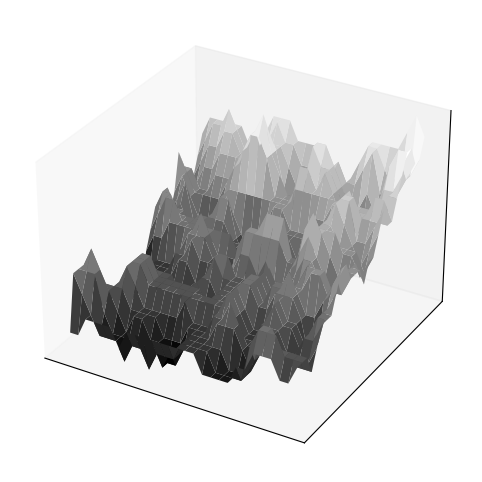

In [49]:
## Plot surface
plot_surface_from_array(dataiterator.next()[0].reshape(28,28), cmap='gray')

### 5.2 Save the model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')